In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import time
import optax
import matplotlib.pyplot as plt 
from jax.flatten_util import ravel_pytree
from functools import partial
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import piml_library.lagrangian as lag
import piml_library.hamiltonian as ham
import piml_library.util as util
import piml_library.early_stopping as es
import piml_library.plotting as plotting
from piml_library.hnn import (
    HamiltonianNN, 
    compute_loss, 
    train_step, 
    create_trajectory,
    create_trajectory_for_lnn
)
import dataset_generator as dg

In [2]:
@jax.jit
#L((t, q, v))
def L_analytical(state):
    q = lag.coordinate(state)
    v = lag.velocity(state)
    q_flat, _ = ravel_pytree(q)
    v_flat, _ = ravel_pytree(v)
    
    T = 0.5 * jnp.sum(v_flat**2)
    V = 0.5 * jnp.sum(q_flat**2)
    return T - V

In [3]:
@jax.jit
#H((t, q, p))
def H_analytical(state, m=1.0, k=1.0):
    q = ham.coordinate(state) 
    p = ham.momentum(state) 
    
    q_flat, _ = ravel_pytree(q) 
    p_flat, _ = ravel_pytree(p) 
    
    T = 0.5 / m * jnp.sum(p_flat**2) 
    V = 0.5 * k * jnp.sum(q_flat**2) 
    return T + V 

In [4]:
# --- ハイパーパラメータ ---
q_dim = 1      
hidden_dim = 300
learning_rate = 1e-3
num_epochs = 10000
key = jax.random.PRNGKey(8)
optimizer = optax.adamw(learning_rate, weight_decay=0)
#es = es.EarlyStopping(patience=100, verbose=True, path='best_lnn_params.pkl', mode='min', save_best_on_disk=False)
#check_interval = 10
#batch_size = 256 

#trajectory
num_trajectories = 100
N_points_per_traj = 30 
t_end = 3.0         
t_eval = jnp.linspace(0.0, t_end, N_points_per_traj)
split_ratio = 0.5
N_points_train = int(N_points_per_traj * split_ratio)


--- 学習用・テスト用データセットの生成開始 ---
Generating 100 trajectories...
--- データセット生成完了 ---
Total Train Points: 1500
Total Test Points:  1500


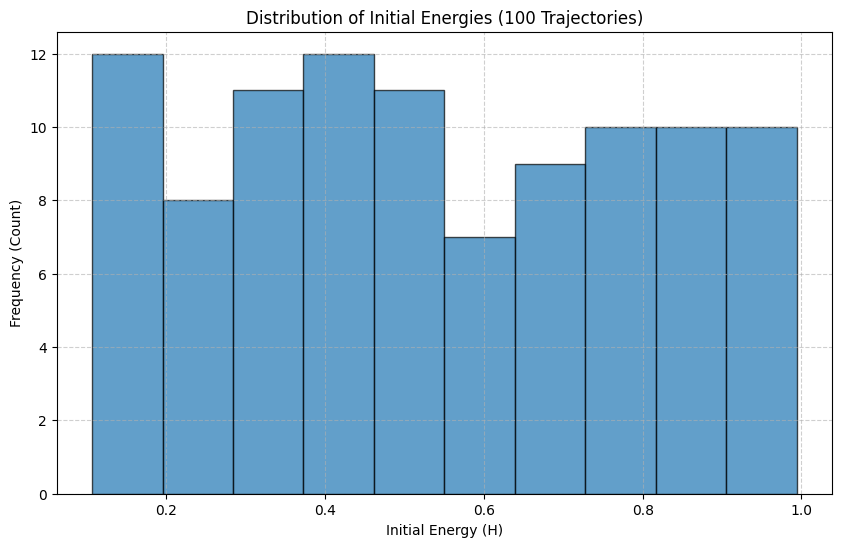

In [5]:
# --- モジュールの関数を呼び出してデータを生成 ---
data_dict = dg.create_trajectory_datasets(
    L_analytical, 
    H_analytical,
    key,
    q_dim=q_dim,
    num_trajectories=num_trajectories,
    N_points_per_traj=N_points_per_traj,
    t_end=t_end,
    split_ratio=split_ratio
)

train_states = data_dict["train_states_hnn"]
train_t, train_q, train_p = train_states
train_targets = data_dict["train_targets_hnn"]
train_q_dot_true, train_p_dot_true = train_targets

test_dataset_states = data_dict["test_dataset_states_hnn"]
test_t, test_q, test_p = test_dataset_states
test_dataset_true_derivatives = data_dict["test_dataset_targets_hnn"]


initial_energies = data_dict["initial_energies"]
N_train_total = data_dict["N_train_total"]

key, _ = jax.random.split(key) 

energies_np = np.array(initial_energies)

plt.figure(figsize=(10, 6))
plt.hist(energies_np, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Initial Energy (H)')
plt.ylabel('Frequency (Count)')
plt.title(f'Distribution of Initial Energies ({num_trajectories} Trajectories)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [6]:
'''
learning Process
'''

# --- モデルとオプティマイザの初期化 ---
hnn_model = HamiltonianNN(hidden_dim=hidden_dim, out_dim=q_dim)
model_apply_fn = hnn_model.apply  
true_derivatives = ham.state_derivative(H_analytical)
vmap_true_derivatives = jax.vmap(
    lambda t, q, p: true_derivatives((t, q, p)),
    in_axes=(0,0,0)
)

key, init_key = jax.random.split(key) 

dummy_q = jnp.zeros((q_dim,))
dummy_p = jnp.zeros((q_dim,))
dummy_state = (0.0, dummy_q, dummy_p)

params = hnn_model.init(init_key, dummy_state)['params'] 
opt_state = optimizer.init(params)

print("モデルとオプティマイザの初期化完了。学習を開始します...")

start_train_time = time.time()

train_loss_history = []
test_loss_history = []
best_test_loss = float('inf') 
best_params = params  
best_epoch = 0

# --- 学習ループ ---
for epoch in range(num_epochs):
    
    params, opt_state, train_loss = train_step(
        params, 
        opt_state, 
        optimizer, 
        model_apply_fn, 
        train_states, 
        train_targets
    )
    test_loss = compute_loss(
        params,
        model_apply_fn,
        test_dataset_states,
        test_dataset_true_derivatives
    )
    
    train_loss_history.append(float(train_loss))
    test_loss_history.append(float(test_loss))
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_epoch = epoch
        best_params = params
        
    if epoch % 100 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")
        
print("学習完了。")

# Final Test Loss
best_test_loss = compute_loss(best_params, model_apply_fn, test_dataset_states, test_dataset_true_derivatives)
best_test_loss.block_until_ready()
end_train_time = time.time()
print(f"--- Final Test Loss: {best_test_loss:.6f} ---")
print(f"--- Total Training Time: {end_train_time - start_train_time:.2f} seconds ---")

モデルとオプティマイザの初期化完了。学習を開始します...
Epoch 0, Train Loss: 0.161662, Test Loss: 0.163224
Epoch 100, Train Loss: 0.000217, Test Loss: 0.000254
Epoch 200, Train Loss: 0.000196, Test Loss: 0.000232
Epoch 300, Train Loss: 0.000175, Test Loss: 0.000209
Epoch 400, Train Loss: 0.000153, Test Loss: 0.000184
Epoch 500, Train Loss: 0.000133, Test Loss: 0.000161
Epoch 600, Train Loss: 0.000113, Test Loss: 0.000138
Epoch 700, Train Loss: 0.000095, Test Loss: 0.000118
Epoch 800, Train Loss: 0.000083, Test Loss: 0.000103
Epoch 900, Train Loss: 0.000068, Test Loss: 0.000086
Epoch 1000, Train Loss: 0.003465, Test Loss: 0.002597
Epoch 1100, Train Loss: 0.000049, Test Loss: 0.000062
Epoch 1200, Train Loss: 0.000037, Test Loss: 0.000049
Epoch 1300, Train Loss: 0.000025, Test Loss: 0.000035
Epoch 1400, Train Loss: 0.000025, Test Loss: 0.000037
Epoch 1500, Train Loss: 0.000015, Test Loss: 0.000022
Epoch 1600, Train Loss: 0.000008, Test Loss: 0.000013
Epoch 1700, Train Loss: 0.000004, Test Loss: 0.000007
Epoch 1800

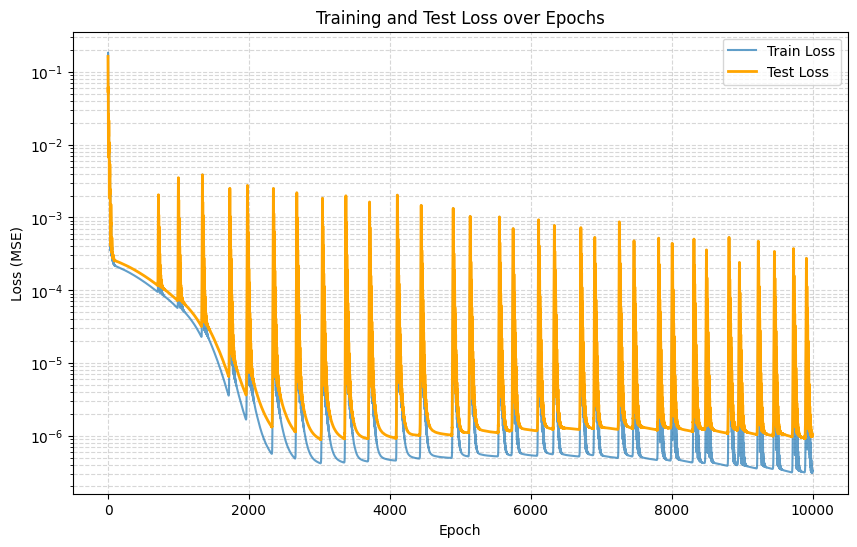

In [7]:
# --- Lossの可視化 ---
plt.figure(figsize=(10, 6))

plt.plot(train_loss_history, label='Train Loss', alpha=0.7)
plt.plot(test_loss_history, label='Test Loss', linewidth=2, color='orange')

plt.yscale('log')  # 縦軸を対数表示にする
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

In [8]:
'''
generate trajectory
'''
HNN_fn = lambda s: model_apply_fn({'params': best_params}, s) 
LNN_from_HNN_fn = ham.hamiltonian_to_lagrangian(HNN_fn)

lag_to_ham_state_fn_true = ham.lagrangian_state_to_hamiltonian_state(L_analytical)
ham_to_lag_state_fn_true = ham.hamiltonian_state_to_lagrangian_state(H_analytical)
lag_to_ham_state_fn_learned = ham.lagrangian_state_to_hamiltonian_state(LNN_from_HNN_fn)
ham_to_lag_state_fn_learned = ham.hamiltonian_state_to_lagrangian_state(HNN_fn)

solver_learned_hnn = create_trajectory(model_apply_fn, best_params)
solver_learned_lnn_from_hnn = create_trajectory_for_lnn(LNN_from_HNN_fn)

# Initial state
initial_states_ham_list = [
    (0.0, jnp.array([jnp.sqrt(0.2*(i+1))]), jnp.array([0.0]))  #H=[0.1, 1.0]の等間隔10点を初期値とする
    for i in range(10)
]
initial_states_lag_list = [
    (0.0, jnp.array([jnp.sqrt(0.2*(i+1))]), jnp.array([0.0]))  #H=[0.1, 1.0]の等間隔10点を初期値とする
    for i in range(10)
]
list_extrapolation = [
    (0.0, jnp.array([jnp.sqrt(0.1)]),  jnp.array([0.0])),
    (0.0, jnp.array([jnp.sqrt(2.1)]),  jnp.array([0.0])),
    (0.0, jnp.array([jnp.sqrt(4.0)]), jnp.array([0.0]))
]
#外挿データを結合する
initial_states_ham_list += list_extrapolation
initial_states_lag_list += list_extrapolation

results_all = []

t_eval = jnp.linspace(0.0, 25.0, 2500) 

#軌道生成のループ
for i, initial_state_ham in enumerate(initial_states_ham_list):
    #true
    ds_true = ham.state_derivative(H_analytical)
    solver_true = util.ode_solver(ds_true)
    ham_states_true = solver_true(initial_state_ham, t_eval) 
    lag_states_true = jax.vmap(ham_to_lag_state_fn_true)(ham_states_true)

    #HNN
    ham_states_learned_hnn = solver_learned_hnn(initial_state_ham, t_eval) 
    lag_states_learned_hnn = jax.vmap(ham_to_lag_state_fn_true)(ham_states_learned_hnn)
    
    #LNN_from_HNN
    initial_state_lnn = ham_to_lag_state_fn_learned(initial_state_ham) 
    lag_states_learned_lnn_from_hnn = solver_learned_lnn_from_hnn(initial_state_lnn, t_eval)
    ham_states_learned_lnn_from_hnn = jax.vmap(lag_to_ham_state_fn_learned)(lag_states_learned_lnn_from_hnn) 
    lag_states_learned_lnn_from_hnn = jax.vmap(ham_to_lag_state_fn_true)(ham_states_learned_lnn_from_hnn)

    res = {
        "id": i,
        "initial_state": initial_state_ham,
        
        # Trueの結果 (ham_states, lag_states)
        "true": (ham_states_true, lag_states_true),
        
        # HNNの結果
        "hnn": (ham_states_learned_hnn, lag_states_learned_hnn),
        
        # LNN from HNNの結果
        "lnn_from_hnn": (ham_states_learned_lnn_from_hnn, lag_states_learned_lnn_from_hnn)
    }
    results_all.append(res)

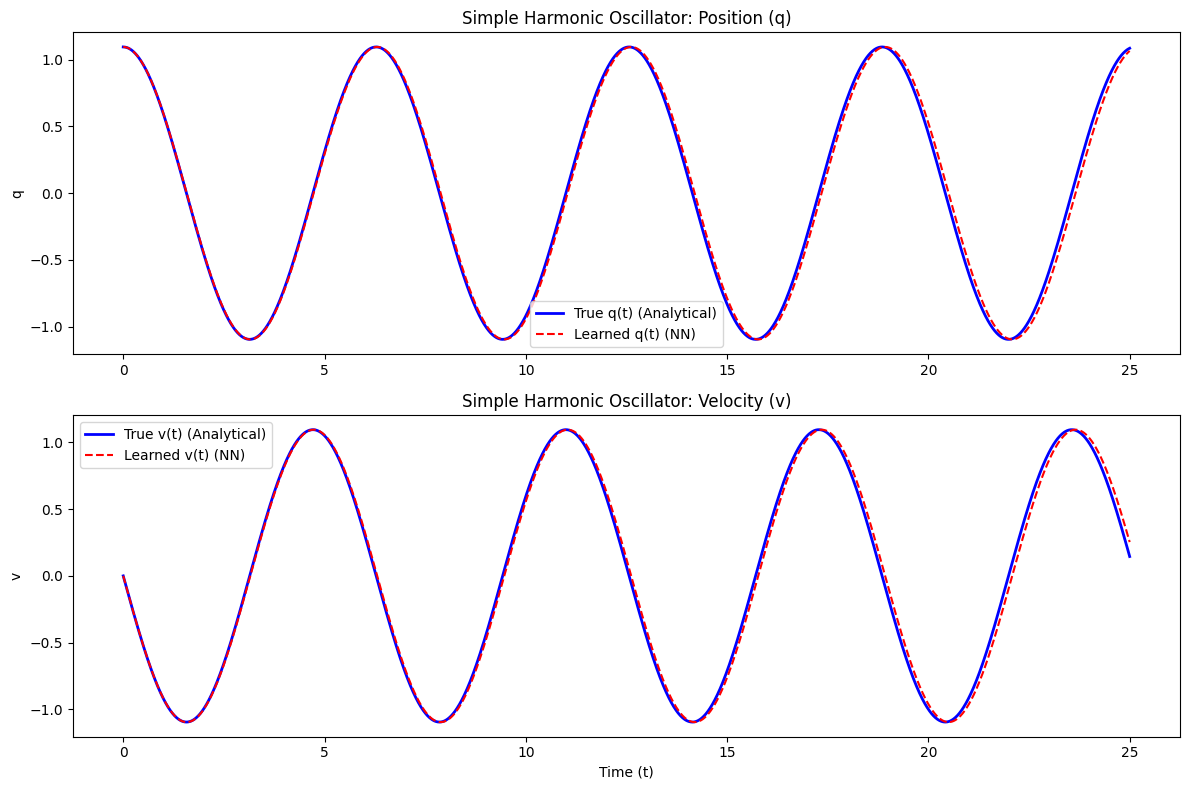

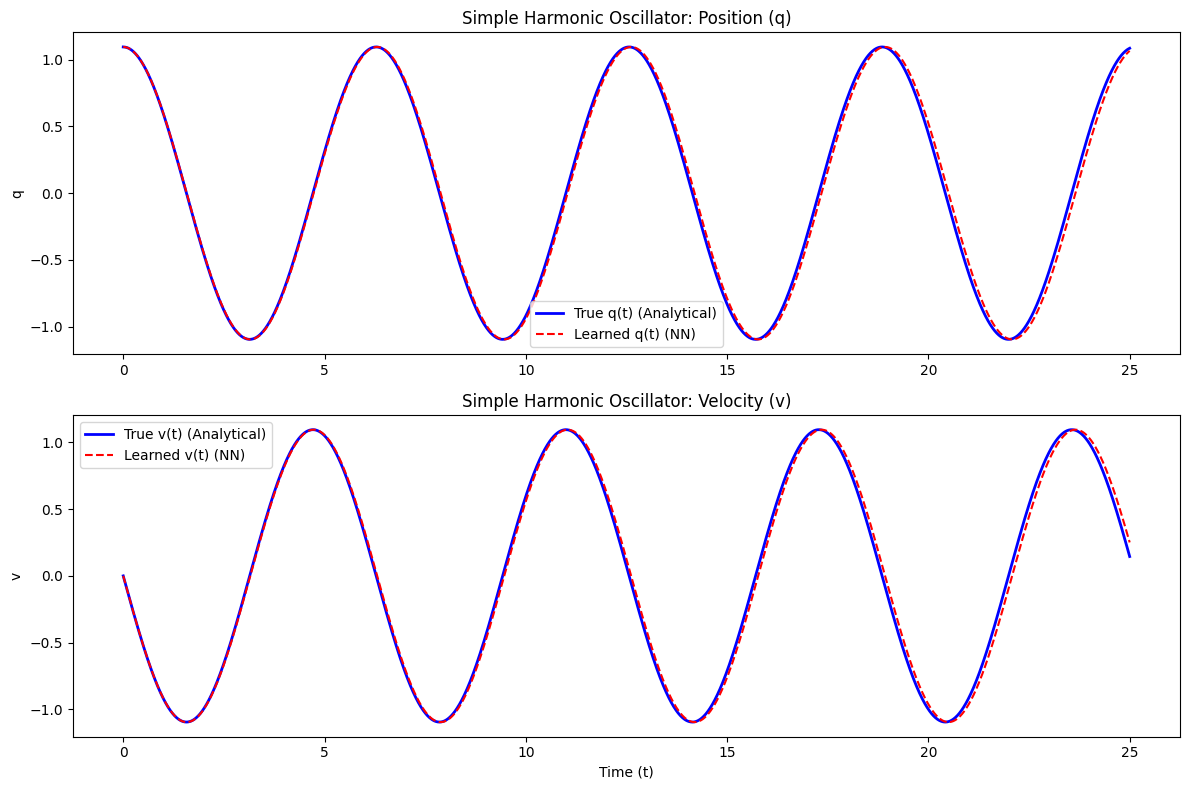

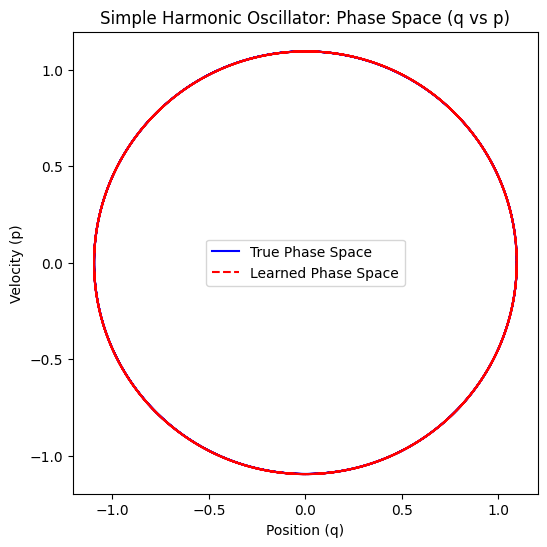

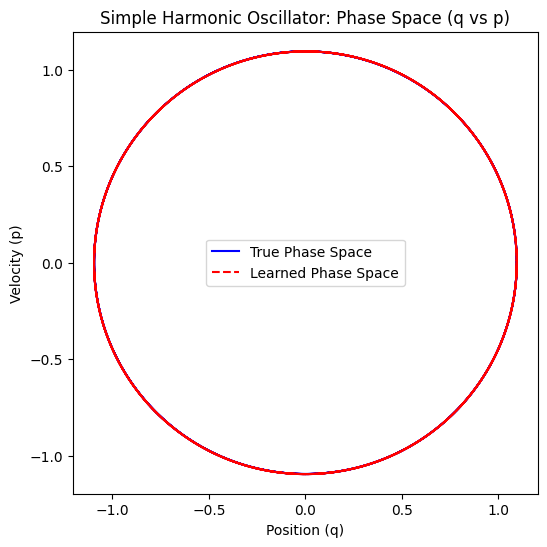

In [9]:
''' 
plot result
'''
# 図示したいデータのインデックスを指定
target_id = 5
res = results_all[target_id]

# True
ham_states_true, lag_states_true = res["true"]
t_true, q_true, p_true = ham_states_true
v_true = lag_states_true[2]

# HNN
ham_states_learned_hnn, lag_states_learned_hnn = res["hnn"]
t_learned_hnn, q_learned_hnn, p_learned_hnn = ham_states_learned_hnn
v_learned_hnn = lag_states_learned_hnn[2]

# LNN from HNN
ham_states_learned_lnn_from_hnn, lag_states_learned_lnn_from_hnn = res["lnn_from_hnn"]
t_learned_lnn_from_hnn, q_learned_lnn_from_hnn, p_learned_lnn_from_hnn = ham_states_learned_lnn_from_hnn
v_learned_lnn_from_hnn = lag_states_learned_lnn_from_hnn[2]

title_prefix="Simple Harmonic Oscillator:"
plotting.plot_trajectory_comparison(
    t_true, q_true, v_true, 
    t_learned_hnn, q_learned_hnn, v_learned_hnn,
    title_prefix
)

plotting.plot_trajectory_comparison(
    t_true, q_true, v_true, 
    t_learned_lnn_from_hnn, q_learned_lnn_from_hnn, v_learned_lnn_from_hnn,
    title_prefix
)

plotting.plot_phase_space(
    q_true, p_true, 
    q_learned_hnn, p_learned_hnn,
    title_prefix
    )

plotting.plot_phase_space(
    q_true, p_true, 
    q_learned_lnn_from_hnn, p_learned_lnn_from_hnn,
    title_prefix
    )

In [10]:
# データを保存
t_true_list, q_true_list, p_true_list, v_true_list = [], [], [], []
t_hnn_list, q_hnn_list, p_hnn_list, v_hnn_list = [], [], [], []
t_lnn_list, q_lnn_list, p_lnn_list, v_lnn_list = [], [], [], []

# results_all から各軌道データを抽出してリストに追加
for res in results_all:

    ham_true, lag_true = res["true"]
    t_true_list.append(ham_true[0])
    q_true_list.append(ham_true[1])
    p_true_list.append(ham_true[2])
    v_true_list.append(lag_true[2])  
    
    ham_hnn, lag_hnn = res["hnn"]
    t_hnn_list.append(ham_hnn[0])
    q_hnn_list.append(ham_hnn[1])
    p_hnn_list.append(ham_hnn[2])
    v_hnn_list.append(lag_hnn[2])
    
    ham_lnn, lag_lnn = res["lnn_from_hnn"]
    t_lnn_list.append(ham_lnn[0])
    q_lnn_list.append(ham_lnn[1])
    p_lnn_list.append(ham_lnn[2])
    v_lnn_list.append(lag_lnn[2])

np.savez(
    "results_H1D_HNN.npz", 
    
    # True
    t_true_hnn=np.array(t_true_list),
    q_true_hnn=np.array(q_true_list),
    v_true_hnn=np.array(v_true_list),
    p_true_hnn=np.array(p_true_list),
    
    # HNN
    t_learned_hnn=np.array(t_hnn_list),
    q_learned_hnn=np.array(q_hnn_list),
    v_learned_hnn=np.array(v_hnn_list),
    p_learned_hnn=np.array(p_hnn_list),
    
    # LNN from HNN
    t_learned_lnn_from_hnn=np.array(t_lnn_list),
    q_learned_lnn_from_hnn=np.array(q_lnn_list),
    v_learned_lnn_from_hnn=np.array(v_lnn_list),
    p_learned_lnn_from_hnn=np.array(p_lnn_list),
)